In [1]:
#Installing all the necessary packages in order to undergo the prediction
import numpy as np
from math import sqrt
import pandas as pd
from pandas import Series , concat
from pandas import DataFrame , datetime
from pandas import read_csv
import pandas as pd
from keras.models import Sequential

Using TensorFlow backend.


In [2]:
#Loading the data set
dataset = pd.read_csv('C:/Users/gurun/Desktop/ProjectCPS/EXP3/DPPdataset.csv',index_col="DATETIME")
dataset.head()

,air temp degree,Air density,wind speed at 100m (m/s),wind direction at 100m (deg),Power (KW)
DATETIME,,,,,
1/1/2007 0:00,2.430,1.223,11.673,244.189,15701
1/1/2007 0:05,2.387,1.224,11.395,244.755,15498
1/1/2007 0:10,2.336,1.224,11.468,245.644,15568
1/1/2007 0:15,2.278,1.224,11.636,246.863,15691
1/1/2007 0:20,2.192,1.225,11.727,247.287,15719


In [3]:
# Framing the the sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df_set = DataFrame(data)
    columns = [df_set.shift(i) for i in range(1, lag+1)]
    columns.append(df_set)
    df_set = concat(columns, axis=1)
    df_set.fillna(0, inplace=True)
    return df_set

In [4]:
# creating a differenced series
def difference(Data_Set, interval=1):
    diff = list()
    for i in range(interval, len(Data_Set)):
        value = Data_Set[i] - Data_Set[i - interval]
        diff.append(value)
    return Series(diff)
# inverting the differenced value
def inverse_difference(history, Y_pred, interval=1):
    return Y_pred + history[-interval]

In [5]:
# Dropping all the features which we will not be using
del dataset['air temp degree']
del dataset['Air density']
del dataset['wind speed at 100m (m/s)']
del dataset['wind direction at 100m (deg)']
for i in range(0,15):
  dataset = dataset[:-1]
dataset.tail()

,Power (KW)
DATETIME,
12/31/2007 22:20,16000
12/31/2007 22:25,16000
12/31/2007 22:30,16000
12/31/2007 22:35,16000
12/31/2007 22:40,16000


In [6]:
# Performing scaling on the train data to [-1, 1]
from sklearn.preprocessing import MinMaxScaler
def scale(Xtrain, Xtest):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(Xtrain)
    Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1])
    Xtrain_scaled = scaler.transform(Xtrain)
    
    
# Performing scaling on the test data to [-1, 1]
    Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1])
    Xtest_scaled = scaler.transform(Xtest)
    return scaler, Xtrain_scaled, Xtest_scaled

In [7]:
# Performing inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    np_rowval = [x for x in X] + [value]
    array = np.array(np_rowval)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [8]:
# Hardcoding all variables
Lag_duration =24
Predict_Value_Size= 8064
Epoch_Size = 6
Batch_Size = 1
Neurons_Size = 10

In [9]:
# fitting the LSTM model into a Training Data set
from keras.layers import Dense, LSTM
from keras.models import Sequential
def fit_lstm(Xtrain, batch_size, nb_epoch, neurons):
    X, y = Xtrain[:, 0:-1], Xtrain[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(Batch_Size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [10]:
# Variables Required for performing forwad walk validation on the test data set
Prediction = list()
Expectation = list()
Pred_plot = list()
Expectation_plot = list()
Test_Prediction = list()

In [11]:
# making an one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    Y_pred = model.predict(X, batch_size=1)
    return Y_pred[0,0]

In [12]:
# transforming the data into a stationary data set
Raw_val = dataset.values
Different_val = difference(Raw_val, 1)
# transforming the data into a  supervised learning
supervised = timeseries_to_supervised(Different_val, Lag_duration)
supervised_values = supervised.values

In [13]:
# splitting the dataset into train-sets and test-sets
Xtrain, Xtest = supervised_values[0:-Predict_Value_Size], supervised_values[-Predict_Value_Size:]
# perform scaling on the data
scaler, Xtrain_scaled, Xtest_scaled = scale(Xtrain, Xtest)

C:\Users\gurun\AppData\Local\conda\conda\envs\tensorflow-sessions\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [14]:
# fitting the LSTM model 
lstm_model = fit_lstm(Xtrain_scaled, Batch_Size, Epoch_Size, Neurons_Size)

Epoch 1/1
97040/97040 [==============================] - 200s 2ms/step - loss: 0.0012
Epoch 1/1
97040/97040 [==============================] - 209s 2ms/step - loss: 0.0011
Epoch 1/1
97040/97040 [==============================] - 211s 2ms/step - loss: 0.0011
Epoch 1/1
97040/97040 [==============================] - 210s 2ms/step - loss: 0.0011
Epoch 1/1
97040/97040 [==============================] - 211s 2ms/step - loss: 0.0011
Epoch 1/1
97040/97040 [==============================] - 210s 2ms/step - loss: 0.0011


In [15]:
for i in range(len(Xtest_scaled)):
    # making one-step forecast
    X, y = Xtest_scaled[i, 0:-1], Xtest_scaled[i, -1]
    Y_pred = forecast_lstm(lstm_model, 1, X)
    # Replacing the values of test scaled data with the newly predicted value.
    Test_Prediction = [Y_pred] + Test_Prediction 
    if len(Test_Prediction) > Lag_duration+1:
        Test_Prediction = Test_Prediction[:-1]
    if i+1<len(Xtest_scaled):
        if i+1 > Lag_duration+1:
            Xtest_scaled[i+1] = Test_Prediction
        else:
            Xtest_scaled[i+1] = np.concatenate((Test_Prediction, Xtest_scaled[i+1, i+1:]),axis=0)

    #Performing the invert scaling and invert differencing and store the forecasted values into an array
    Y_pred = invert_scale(scaler, X, Y_pred)
    Y_pred = inverse_difference(Raw_val, Y_pred, len(Xtest_scaled)+1-i)
    Expected_Val = Raw_val[len(Xtrain) + i + 1]
    Pred_plot.append(Y_pred)
    Expectation_plot.append(Expected_Val)
    if Expected_Val != 0:
        Prediction.append(Y_pred)
        Expectation.append(Expected_Val)
    print('Every 5th Minute Entry=%d, Predicted_Value=%f, Expected_Value=%f' % (i+1, Y_pred, Expected_Val))

Expectation = np.array(Expectation)
Prediction = np.array(Prediction)

Every 5th Minute Entry=1, Predicted_Value=716.145162, Expected_Value=722.000000
Every 5th Minute Entry=2, Predicted_Value=613.898810, Expected_Value=671.000000
Every 5th Minute Entry=3, Predicted_Value=512.560886, Expected_Value=650.000000
Every 5th Minute Entry=4, Predicted_Value=468.638301, Expected_Value=648.000000
Every 5th Minute Entry=5, Predicted_Value=467.895048, Expected_Value=652.000000
Every 5th Minute Entry=6, Predicted_Value=483.382567, Expected_Value=639.000000
Every 5th Minute Entry=7, Predicted_Value=484.663397, Expected_Value=625.000000
Every 5th Minute Entry=8, Predicted_Value=483.094388, Expected_Value=612.000000
Every 5th Minute Entry=9, Predicted_Value=483.429869, Expected_Value=585.000000
Every 5th Minute Entry=10, Predicted_Value=474.425288, Expected_Value=542.000000
Every 5th Minute Entry=11, Predicted_Value=454.442729, Expected_Value=491.000000
Every 5th Minute Entry=12, Predicted_Value=425.888277, Expected_Value=435.000000
Every 5th Minute Entry=13, Predicted_

Every 5th Minute Entry=163, Predicted_Value=126.898419, Expected_Value=148.000000
Every 5th Minute Entry=164, Predicted_Value=93.238528, Expected_Value=121.000000
Every 5th Minute Entry=165, Predicted_Value=66.525192, Expected_Value=112.000000
Every 5th Minute Entry=166, Predicted_Value=57.752667, Expected_Value=110.000000
Every 5th Minute Entry=167, Predicted_Value=55.917311, Expected_Value=118.000000
Every 5th Minute Entry=168, Predicted_Value=64.017577, Expected_Value=138.000000
Every 5th Minute Entry=169, Predicted_Value=84.054017, Expected_Value=156.000000
Every 5th Minute Entry=170, Predicted_Value=102.028951, Expected_Value=171.000000
Every 5th Minute Entry=171, Predicted_Value=116.946132, Expected_Value=186.000000
Every 5th Minute Entry=172, Predicted_Value=131.810751, Expected_Value=206.000000
Every 5th Minute Entry=173, Predicted_Value=151.629433, Expected_Value=215.000000
Every 5th Minute Entry=174, Predicted_Value=160.409245, Expected_Value=217.000000
Every 5th Minute Entry

Every 5th Minute Entry=308, Predicted_Value=4780.951635, Expected_Value=4624.000000
Every 5th Minute Entry=309, Predicted_Value=4567.965106, Expected_Value=4412.000000
Every 5th Minute Entry=310, Predicted_Value=4355.977805, Expected_Value=4234.000000
Every 5th Minute Entry=311, Predicted_Value=4177.989400, Expected_Value=4057.000000
Every 5th Minute Entry=312, Predicted_Value=4000.999449, Expected_Value=3901.000000
Every 5th Minute Entry=313, Predicted_Value=3845.007951, Expected_Value=3783.000000
Every 5th Minute Entry=314, Predicted_Value=3727.014798, Expected_Value=3697.000000
Every 5th Minute Entry=315, Predicted_Value=3641.019656, Expected_Value=3627.000000
Every 5th Minute Entry=316, Predicted_Value=3571.022527, Expected_Value=3530.000000
Every 5th Minute Entry=317, Predicted_Value=3474.023742, Expected_Value=3407.000000
Every 5th Minute Entry=318, Predicted_Value=3351.023190, Expected_Value=3294.000000
Every 5th Minute Entry=319, Predicted_Value=3238.020540, Expected_Value=3224

Every 5th Minute Entry=446, Predicted_Value=11725.957266, Expected_Value=11899.000000
Every 5th Minute Entry=447, Predicted_Value=11842.957266, Expected_Value=11731.000000
Every 5th Minute Entry=448, Predicted_Value=11674.957487, Expected_Value=11634.000000
Every 5th Minute Entry=449, Predicted_Value=11577.957708, Expected_Value=11386.000000
Every 5th Minute Entry=450, Predicted_Value=11329.957818, Expected_Value=11059.000000
Every 5th Minute Entry=451, Predicted_Value=11002.958150, Expected_Value=10624.000000
Every 5th Minute Entry=452, Predicted_Value=10567.958481, Expected_Value=10136.000000
Every 5th Minute Entry=453, Predicted_Value=10079.958923, Expected_Value=9791.000000
Every 5th Minute Entry=454, Predicted_Value=9734.959475, Expected_Value=9685.000000
Every 5th Minute Entry=455, Predicted_Value=9628.959916, Expected_Value=9668.000000
Every 5th Minute Entry=456, Predicted_Value=9611.960358, Expected_Value=9705.000000
Every 5th Minute Entry=457, Predicted_Value=9648.960689, Expe

Every 5th Minute Entry=609, Predicted_Value=-56.039531, Expected_Value=0.000000
Every 5th Minute Entry=610, Predicted_Value=-56.039531, Expected_Value=0.000000
Every 5th Minute Entry=611, Predicted_Value=-56.039642, Expected_Value=0.000000
Every 5th Minute Entry=612, Predicted_Value=-56.039642, Expected_Value=0.000000
Every 5th Minute Entry=613, Predicted_Value=-56.039642, Expected_Value=0.000000
Every 5th Minute Entry=614, Predicted_Value=-56.039642, Expected_Value=0.000000
Every 5th Minute Entry=615, Predicted_Value=-56.039642, Expected_Value=0.000000
Every 5th Minute Entry=616, Predicted_Value=-56.039642, Expected_Value=0.000000
Every 5th Minute Entry=617, Predicted_Value=-56.039642, Expected_Value=0.000000
Every 5th Minute Entry=618, Predicted_Value=-56.039642, Expected_Value=0.000000
Every 5th Minute Entry=619, Predicted_Value=-56.039642, Expected_Value=0.000000
Every 5th Minute Entry=620, Predicted_Value=-56.039642, Expected_Value=0.000000
Every 5th Minute Entry=621, Predicted_Va

Every 5th Minute Entry=761, Predicted_Value=2642.960358, Expected_Value=2611.000000
Every 5th Minute Entry=762, Predicted_Value=2554.960358, Expected_Value=2502.000000
Every 5th Minute Entry=763, Predicted_Value=2445.960358, Expected_Value=2241.000000
Every 5th Minute Entry=764, Predicted_Value=2184.960358, Expected_Value=2133.000000
Every 5th Minute Entry=765, Predicted_Value=2076.960358, Expected_Value=2036.000000
Every 5th Minute Entry=766, Predicted_Value=1979.960358, Expected_Value=2032.000000
Every 5th Minute Entry=767, Predicted_Value=1975.960248, Expected_Value=1993.000000
Every 5th Minute Entry=768, Predicted_Value=1936.960137, Expected_Value=1781.000000
Every 5th Minute Entry=769, Predicted_Value=1724.960248, Expected_Value=1638.000000
Every 5th Minute Entry=770, Predicted_Value=1581.960358, Expected_Value=1499.000000
Every 5th Minute Entry=771, Predicted_Value=1442.960358, Expected_Value=1638.000000
Every 5th Minute Entry=772, Predicted_Value=1581.960248, Expected_Value=1595

Every 5th Minute Entry=887, Predicted_Value=4080.960248, Expected_Value=4066.000000
Every 5th Minute Entry=888, Predicted_Value=4009.960248, Expected_Value=3993.000000
Every 5th Minute Entry=889, Predicted_Value=3936.960248, Expected_Value=3912.000000
Every 5th Minute Entry=890, Predicted_Value=3855.960248, Expected_Value=3879.000000
Every 5th Minute Entry=891, Predicted_Value=3822.960358, Expected_Value=3857.000000
Every 5th Minute Entry=892, Predicted_Value=3800.960469, Expected_Value=3825.000000
Every 5th Minute Entry=893, Predicted_Value=3768.960579, Expected_Value=3901.000000
Every 5th Minute Entry=894, Predicted_Value=3844.960469, Expected_Value=4016.000000
Every 5th Minute Entry=895, Predicted_Value=3959.960469, Expected_Value=4230.000000
Every 5th Minute Entry=896, Predicted_Value=4173.960358, Expected_Value=4459.000000
Every 5th Minute Entry=897, Predicted_Value=4402.960358, Expected_Value=4623.000000
Every 5th Minute Entry=898, Predicted_Value=4566.960358, Expected_Value=4752

Every 5th Minute Entry=1026, Predicted_Value=-9.039752, Expected_Value=45.000000
Every 5th Minute Entry=1027, Predicted_Value=-11.039752, Expected_Value=44.000000
Every 5th Minute Entry=1028, Predicted_Value=-12.039752, Expected_Value=41.000000
Every 5th Minute Entry=1029, Predicted_Value=-15.039642, Expected_Value=38.000000
Every 5th Minute Entry=1030, Predicted_Value=-18.039531, Expected_Value=36.000000
Every 5th Minute Entry=1031, Predicted_Value=-20.039531, Expected_Value=33.000000
Every 5th Minute Entry=1032, Predicted_Value=-23.039531, Expected_Value=31.000000
Every 5th Minute Entry=1033, Predicted_Value=-25.039642, Expected_Value=29.000000
Every 5th Minute Entry=1034, Predicted_Value=-27.039752, Expected_Value=28.000000
Every 5th Minute Entry=1035, Predicted_Value=-28.039863, Expected_Value=27.000000
Every 5th Minute Entry=1036, Predicted_Value=-29.039863, Expected_Value=27.000000
Every 5th Minute Entry=1037, Predicted_Value=-29.039863, Expected_Value=26.000000
Every 5th Minute 

Every 5th Minute Entry=1165, Predicted_Value=4659.960137, Expected_Value=4639.000000
Every 5th Minute Entry=1166, Predicted_Value=4582.960137, Expected_Value=4798.000000
Every 5th Minute Entry=1167, Predicted_Value=4741.960248, Expected_Value=4936.000000
Every 5th Minute Entry=1168, Predicted_Value=4879.960248, Expected_Value=4808.000000
Every 5th Minute Entry=1169, Predicted_Value=4751.960248, Expected_Value=4860.000000
Every 5th Minute Entry=1170, Predicted_Value=4803.960248, Expected_Value=4847.000000
Every 5th Minute Entry=1171, Predicted_Value=4790.960248, Expected_Value=4763.000000
Every 5th Minute Entry=1172, Predicted_Value=4706.960248, Expected_Value=4980.000000
Every 5th Minute Entry=1173, Predicted_Value=4923.960248, Expected_Value=5176.000000
Every 5th Minute Entry=1174, Predicted_Value=5119.960248, Expected_Value=5307.000000
Every 5th Minute Entry=1175, Predicted_Value=5250.960248, Expected_Value=5403.000000
Every 5th Minute Entry=1176, Predicted_Value=5346.960248, Expecte

Every 5th Minute Entry=1302, Predicted_Value=1675.960137, Expected_Value=1883.000000
Every 5th Minute Entry=1303, Predicted_Value=1826.960137, Expected_Value=2029.000000
Every 5th Minute Entry=1304, Predicted_Value=1972.960137, Expected_Value=2141.000000
Every 5th Minute Entry=1305, Predicted_Value=2084.960137, Expected_Value=2236.000000
Every 5th Minute Entry=1306, Predicted_Value=2179.960137, Expected_Value=2284.000000
Every 5th Minute Entry=1307, Predicted_Value=2227.960137, Expected_Value=2250.000000
Every 5th Minute Entry=1308, Predicted_Value=2193.960248, Expected_Value=2266.000000
Every 5th Minute Entry=1309, Predicted_Value=2209.960358, Expected_Value=2146.000000
Every 5th Minute Entry=1310, Predicted_Value=2089.960469, Expected_Value=2017.000000
Every 5th Minute Entry=1311, Predicted_Value=1960.960469, Expected_Value=1896.000000
Every 5th Minute Entry=1312, Predicted_Value=1839.960469, Expected_Value=1846.000000
Every 5th Minute Entry=1313, Predicted_Value=1789.960469, Expecte

Every 5th Minute Entry=1429, Predicted_Value=2785.960358, Expected_Value=3082.000000
Every 5th Minute Entry=1430, Predicted_Value=3025.960358, Expected_Value=2940.000000
Every 5th Minute Entry=1431, Predicted_Value=2883.960358, Expected_Value=2754.000000
Every 5th Minute Entry=1432, Predicted_Value=2697.960469, Expected_Value=2639.000000
Every 5th Minute Entry=1433, Predicted_Value=2582.960579, Expected_Value=3098.000000
Every 5th Minute Entry=1434, Predicted_Value=3041.960579, Expected_Value=2743.000000
Every 5th Minute Entry=1435, Predicted_Value=2686.960469, Expected_Value=2557.000000
Every 5th Minute Entry=1436, Predicted_Value=2500.960248, Expected_Value=3048.000000
Every 5th Minute Entry=1437, Predicted_Value=2991.960137, Expected_Value=3446.000000
Every 5th Minute Entry=1438, Predicted_Value=3389.960137, Expected_Value=3413.000000
Every 5th Minute Entry=1439, Predicted_Value=3356.960137, Expected_Value=3184.000000
Every 5th Minute Entry=1440, Predicted_Value=3127.960137, Expecte

Every 5th Minute Entry=1549, Predicted_Value=5082.960358, Expected_Value=4378.000000
Every 5th Minute Entry=1550, Predicted_Value=4321.960358, Expected_Value=4708.000000
Every 5th Minute Entry=1551, Predicted_Value=4651.960358, Expected_Value=3642.000000
Every 5th Minute Entry=1552, Predicted_Value=3585.960358, Expected_Value=3603.000000
Every 5th Minute Entry=1553, Predicted_Value=3546.960358, Expected_Value=3598.000000
Every 5th Minute Entry=1554, Predicted_Value=3541.960358, Expected_Value=2743.000000
Every 5th Minute Entry=1555, Predicted_Value=2686.960358, Expected_Value=2252.000000
Every 5th Minute Entry=1556, Predicted_Value=2195.960358, Expected_Value=1835.000000
Every 5th Minute Entry=1557, Predicted_Value=1778.960358, Expected_Value=1096.000000
Every 5th Minute Entry=1558, Predicted_Value=1039.960358, Expected_Value=633.000000
Every 5th Minute Entry=1559, Predicted_Value=576.960248, Expected_Value=424.000000
Every 5th Minute Entry=1560, Predicted_Value=367.960137, Expected_Va

Every 5th Minute Entry=1681, Predicted_Value=460.960358, Expected_Value=502.000000
Every 5th Minute Entry=1682, Predicted_Value=445.960469, Expected_Value=484.000000
Every 5th Minute Entry=1683, Predicted_Value=427.960469, Expected_Value=497.000000
Every 5th Minute Entry=1684, Predicted_Value=440.960469, Expected_Value=454.000000
Every 5th Minute Entry=1685, Predicted_Value=397.960358, Expected_Value=481.000000
Every 5th Minute Entry=1686, Predicted_Value=424.960248, Expected_Value=499.000000
Every 5th Minute Entry=1687, Predicted_Value=442.960137, Expected_Value=459.000000
Every 5th Minute Entry=1688, Predicted_Value=402.960137, Expected_Value=407.000000
Every 5th Minute Entry=1689, Predicted_Value=350.960137, Expected_Value=309.000000
Every 5th Minute Entry=1690, Predicted_Value=252.960137, Expected_Value=249.000000
Every 5th Minute Entry=1691, Predicted_Value=192.960137, Expected_Value=231.000000
Every 5th Minute Entry=1692, Predicted_Value=174.960248, Expected_Value=193.000000
Ever

Every 5th Minute Entry=1817, Predicted_Value=-20.039863, Expected_Value=35.000000
Every 5th Minute Entry=1818, Predicted_Value=-21.039863, Expected_Value=29.000000
Every 5th Minute Entry=1819, Predicted_Value=-27.039752, Expected_Value=27.000000
Every 5th Minute Entry=1820, Predicted_Value=-29.039752, Expected_Value=32.000000
Every 5th Minute Entry=1821, Predicted_Value=-24.039752, Expected_Value=38.000000
Every 5th Minute Entry=1822, Predicted_Value=-18.039752, Expected_Value=32.000000
Every 5th Minute Entry=1823, Predicted_Value=-24.039752, Expected_Value=21.000000
Every 5th Minute Entry=1824, Predicted_Value=-35.039752, Expected_Value=18.000000
Every 5th Minute Entry=1825, Predicted_Value=-38.039752, Expected_Value=17.000000
Every 5th Minute Entry=1826, Predicted_Value=-39.039752, Expected_Value=14.000000
Every 5th Minute Entry=1827, Predicted_Value=-42.039752, Expected_Value=11.000000
Every 5th Minute Entry=1828, Predicted_Value=-45.039752, Expected_Value=4.000000
Every 5th Minute 

Every 5th Minute Entry=1934, Predicted_Value=-56.039531, Expected_Value=0.000000
Every 5th Minute Entry=1935, Predicted_Value=-56.039531, Expected_Value=0.000000
Every 5th Minute Entry=1936, Predicted_Value=-56.039531, Expected_Value=0.000000
Every 5th Minute Entry=1937, Predicted_Value=-56.039642, Expected_Value=0.000000
Every 5th Minute Entry=1938, Predicted_Value=-56.039642, Expected_Value=0.000000
Every 5th Minute Entry=1939, Predicted_Value=-56.039642, Expected_Value=0.000000
Every 5th Minute Entry=1940, Predicted_Value=-56.039642, Expected_Value=0.000000
Every 5th Minute Entry=1941, Predicted_Value=-56.039642, Expected_Value=0.000000
Every 5th Minute Entry=1942, Predicted_Value=-56.039642, Expected_Value=0.000000
Every 5th Minute Entry=1943, Predicted_Value=-56.039642, Expected_Value=0.000000
Every 5th Minute Entry=1944, Predicted_Value=-56.039642, Expected_Value=0.000000
Every 5th Minute Entry=1945, Predicted_Value=-56.039642, Expected_Value=0.000000
Every 5th Minute Entry=1946,

Every 5th Minute Entry=2050, Predicted_Value=1807.960469, Expected_Value=845.000000
Every 5th Minute Entry=2051, Predicted_Value=788.960358, Expected_Value=620.000000
Every 5th Minute Entry=2052, Predicted_Value=563.960358, Expected_Value=751.000000
Every 5th Minute Entry=2053, Predicted_Value=694.960469, Expected_Value=942.000000
Every 5th Minute Entry=2054, Predicted_Value=885.960469, Expected_Value=110.000000
Every 5th Minute Entry=2055, Predicted_Value=53.960469, Expected_Value=12.000000
Every 5th Minute Entry=2056, Predicted_Value=-44.039642, Expected_Value=64.000000
Every 5th Minute Entry=2057, Predicted_Value=7.960248, Expected_Value=25.000000
Every 5th Minute Entry=2058, Predicted_Value=-31.039752, Expected_Value=0.000000
Every 5th Minute Entry=2059, Predicted_Value=-56.039752, Expected_Value=27.000000
Every 5th Minute Entry=2060, Predicted_Value=-29.039752, Expected_Value=32.000000
Every 5th Minute Entry=2061, Predicted_Value=-24.039752, Expected_Value=6.000000
Every 5th Minut

Every 5th Minute Entry=2184, Predicted_Value=167.960248, Expected_Value=84.000000
Every 5th Minute Entry=2185, Predicted_Value=27.960248, Expected_Value=49.000000
Every 5th Minute Entry=2186, Predicted_Value=-7.039752, Expected_Value=44.000000
Every 5th Minute Entry=2187, Predicted_Value=-12.039752, Expected_Value=41.000000
Every 5th Minute Entry=2188, Predicted_Value=-15.039752, Expected_Value=30.000000
Every 5th Minute Entry=2189, Predicted_Value=-26.039752, Expected_Value=13.000000
Every 5th Minute Entry=2190, Predicted_Value=-43.039752, Expected_Value=36.000000
Every 5th Minute Entry=2191, Predicted_Value=-20.039752, Expected_Value=79.000000
Every 5th Minute Entry=2192, Predicted_Value=22.960248, Expected_Value=190.000000
Every 5th Minute Entry=2193, Predicted_Value=133.960248, Expected_Value=232.000000
Every 5th Minute Entry=2194, Predicted_Value=175.960248, Expected_Value=517.000000
Every 5th Minute Entry=2195, Predicted_Value=460.960358, Expected_Value=574.000000
Every 5th Minut

Every 5th Minute Entry=2301, Predicted_Value=5902.960248, Expected_Value=5360.000000
Every 5th Minute Entry=2302, Predicted_Value=5303.960248, Expected_Value=5204.000000
Every 5th Minute Entry=2303, Predicted_Value=5147.960248, Expected_Value=5055.000000
Every 5th Minute Entry=2304, Predicted_Value=4998.960248, Expected_Value=5048.000000
Every 5th Minute Entry=2305, Predicted_Value=4991.960248, Expected_Value=4586.000000
Every 5th Minute Entry=2306, Predicted_Value=4529.960248, Expected_Value=4451.000000
Every 5th Minute Entry=2307, Predicted_Value=4394.960248, Expected_Value=4894.000000
Every 5th Minute Entry=2308, Predicted_Value=4837.960248, Expected_Value=5416.000000
Every 5th Minute Entry=2309, Predicted_Value=5359.960248, Expected_Value=6723.000000
Every 5th Minute Entry=2310, Predicted_Value=6666.960248, Expected_Value=8299.000000
Every 5th Minute Entry=2311, Predicted_Value=8242.960248, Expected_Value=8968.000000
Every 5th Minute Entry=2312, Predicted_Value=8911.960248, Expecte

Every 5th Minute Entry=2419, Predicted_Value=1091.960137, Expected_Value=1113.000000
Every 5th Minute Entry=2420, Predicted_Value=1056.960137, Expected_Value=1106.000000
Every 5th Minute Entry=2421, Predicted_Value=1049.960248, Expected_Value=1079.000000
Every 5th Minute Entry=2422, Predicted_Value=1022.960248, Expected_Value=1071.000000
Every 5th Minute Entry=2423, Predicted_Value=1014.960248, Expected_Value=1060.000000
Every 5th Minute Entry=2424, Predicted_Value=1003.960248, Expected_Value=983.000000
Every 5th Minute Entry=2425, Predicted_Value=926.960358, Expected_Value=874.000000
Every 5th Minute Entry=2426, Predicted_Value=817.960469, Expected_Value=809.000000
Every 5th Minute Entry=2427, Predicted_Value=752.960469, Expected_Value=773.000000
Every 5th Minute Entry=2428, Predicted_Value=716.960469, Expected_Value=776.000000
Every 5th Minute Entry=2429, Predicted_Value=719.960358, Expected_Value=753.000000
Every 5th Minute Entry=2430, Predicted_Value=696.960248, Expected_Value=726.

Every 5th Minute Entry=2558, Predicted_Value=4.960579, Expected_Value=71.000000
Every 5th Minute Entry=2559, Predicted_Value=14.960579, Expected_Value=80.000000
Every 5th Minute Entry=2560, Predicted_Value=23.960469, Expected_Value=84.000000
Every 5th Minute Entry=2561, Predicted_Value=27.960358, Expected_Value=78.000000
Every 5th Minute Entry=2562, Predicted_Value=21.960358, Expected_Value=75.000000
Every 5th Minute Entry=2563, Predicted_Value=18.960358, Expected_Value=74.000000
Every 5th Minute Entry=2564, Predicted_Value=17.960358, Expected_Value=86.000000
Every 5th Minute Entry=2565, Predicted_Value=29.960358, Expected_Value=177.000000
Every 5th Minute Entry=2566, Predicted_Value=120.960248, Expected_Value=88.000000
Every 5th Minute Entry=2567, Predicted_Value=31.960137, Expected_Value=90.000000
Every 5th Minute Entry=2568, Predicted_Value=33.960137, Expected_Value=183.000000
Every 5th Minute Entry=2569, Predicted_Value=126.960137, Expected_Value=272.000000
Every 5th Minute Entry=2

Every 5th Minute Entry=2675, Predicted_Value=2689.960469, Expected_Value=3011.000000
Every 5th Minute Entry=2676, Predicted_Value=2954.960469, Expected_Value=3331.000000
Every 5th Minute Entry=2677, Predicted_Value=3274.960469, Expected_Value=3651.000000
Every 5th Minute Entry=2678, Predicted_Value=3594.960469, Expected_Value=3846.000000
Every 5th Minute Entry=2679, Predicted_Value=3789.960358, Expected_Value=3965.000000
Every 5th Minute Entry=2680, Predicted_Value=3908.960248, Expected_Value=4093.000000
Every 5th Minute Entry=2681, Predicted_Value=4036.960248, Expected_Value=4307.000000
Every 5th Minute Entry=2682, Predicted_Value=4250.960248, Expected_Value=4470.000000
Every 5th Minute Entry=2683, Predicted_Value=4413.960248, Expected_Value=4784.000000
Every 5th Minute Entry=2684, Predicted_Value=4727.960248, Expected_Value=5012.000000
Every 5th Minute Entry=2685, Predicted_Value=4955.960248, Expected_Value=5284.000000
Every 5th Minute Entry=2686, Predicted_Value=5227.960358, Expecte

Every 5th Minute Entry=2798, Predicted_Value=10817.960248, Expected_Value=11025.000000
Every 5th Minute Entry=2799, Predicted_Value=10968.960248, Expected_Value=11381.000000
Every 5th Minute Entry=2800, Predicted_Value=11324.960248, Expected_Value=11789.000000
Every 5th Minute Entry=2801, Predicted_Value=11732.960248, Expected_Value=12269.000000
Every 5th Minute Entry=2802, Predicted_Value=12212.960248, Expected_Value=12760.000000
Every 5th Minute Entry=2803, Predicted_Value=12703.960248, Expected_Value=13171.000000
Every 5th Minute Entry=2804, Predicted_Value=13114.960248, Expected_Value=13539.000000
Every 5th Minute Entry=2805, Predicted_Value=13482.960248, Expected_Value=13975.000000
Every 5th Minute Entry=2806, Predicted_Value=13918.960248, Expected_Value=14398.000000
Every 5th Minute Entry=2807, Predicted_Value=14341.960248, Expected_Value=14542.000000
Every 5th Minute Entry=2808, Predicted_Value=14485.960358, Expected_Value=14500.000000
Every 5th Minute Entry=2809, Predicted_Valu

Every 5th Minute Entry=2921, Predicted_Value=9346.960358, Expected_Value=9370.000000
Every 5th Minute Entry=2922, Predicted_Value=9313.960358, Expected_Value=9202.000000
Every 5th Minute Entry=2923, Predicted_Value=9145.960358, Expected_Value=9114.000000
Every 5th Minute Entry=2924, Predicted_Value=9057.960358, Expected_Value=9407.000000
Every 5th Minute Entry=2925, Predicted_Value=9350.960358, Expected_Value=9878.000000
Every 5th Minute Entry=2926, Predicted_Value=9821.960248, Expected_Value=10268.000000
Every 5th Minute Entry=2927, Predicted_Value=10211.960137, Expected_Value=10579.000000
Every 5th Minute Entry=2928, Predicted_Value=10522.960137, Expected_Value=10800.000000
Every 5th Minute Entry=2929, Predicted_Value=10743.960137, Expected_Value=10904.000000
Every 5th Minute Entry=2930, Predicted_Value=10847.960137, Expected_Value=10953.000000
Every 5th Minute Entry=2931, Predicted_Value=10896.960137, Expected_Value=10787.000000
Every 5th Minute Entry=2932, Predicted_Value=10730.960

Every 5th Minute Entry=3048, Predicted_Value=4.960469, Expected_Value=66.000000
Every 5th Minute Entry=3049, Predicted_Value=9.960469, Expected_Value=69.000000
Every 5th Minute Entry=3050, Predicted_Value=12.960358, Expected_Value=71.000000
Every 5th Minute Entry=3051, Predicted_Value=14.960248, Expected_Value=70.000000
Every 5th Minute Entry=3052, Predicted_Value=13.960248, Expected_Value=68.000000
Every 5th Minute Entry=3053, Predicted_Value=11.960248, Expected_Value=67.000000
Every 5th Minute Entry=3054, Predicted_Value=10.960248, Expected_Value=67.000000
Every 5th Minute Entry=3055, Predicted_Value=10.960248, Expected_Value=70.000000
Every 5th Minute Entry=3056, Predicted_Value=13.960248, Expected_Value=74.000000
Every 5th Minute Entry=3057, Predicted_Value=17.960248, Expected_Value=75.000000
Every 5th Minute Entry=3058, Predicted_Value=18.960248, Expected_Value=77.000000
Every 5th Minute Entry=3059, Predicted_Value=20.960358, Expected_Value=81.000000
Every 5th Minute Entry=3060, P

Every 5th Minute Entry=3177, Predicted_Value=2012.960469, Expected_Value=2450.000000
Every 5th Minute Entry=3178, Predicted_Value=2393.960358, Expected_Value=2663.000000
Every 5th Minute Entry=3179, Predicted_Value=2606.960358, Expected_Value=2625.000000
Every 5th Minute Entry=3180, Predicted_Value=2568.960358, Expected_Value=2701.000000
Every 5th Minute Entry=3181, Predicted_Value=2644.960358, Expected_Value=2723.000000
Every 5th Minute Entry=3182, Predicted_Value=2666.960358, Expected_Value=2532.000000
Every 5th Minute Entry=3183, Predicted_Value=2475.960358, Expected_Value=2270.000000
Every 5th Minute Entry=3184, Predicted_Value=2213.960358, Expected_Value=2102.000000
Every 5th Minute Entry=3185, Predicted_Value=2045.960358, Expected_Value=2082.000000
Every 5th Minute Entry=3186, Predicted_Value=2025.960358, Expected_Value=2279.000000
Every 5th Minute Entry=3187, Predicted_Value=2222.960358, Expected_Value=2317.000000
Every 5th Minute Entry=3188, Predicted_Value=2260.960358, Expecte

Every 5th Minute Entry=3302, Predicted_Value=4804.960469, Expected_Value=5203.000000
Every 5th Minute Entry=3303, Predicted_Value=5146.960358, Expected_Value=4902.000000
Every 5th Minute Entry=3304, Predicted_Value=4845.960358, Expected_Value=4744.000000
Every 5th Minute Entry=3305, Predicted_Value=4687.960358, Expected_Value=4543.000000
Every 5th Minute Entry=3306, Predicted_Value=4486.960358, Expected_Value=4292.000000
Every 5th Minute Entry=3307, Predicted_Value=4235.960248, Expected_Value=3796.000000
Every 5th Minute Entry=3308, Predicted_Value=3739.960248, Expected_Value=3567.000000
Every 5th Minute Entry=3309, Predicted_Value=3510.960248, Expected_Value=3979.000000
Every 5th Minute Entry=3310, Predicted_Value=3922.960248, Expected_Value=4674.000000
Every 5th Minute Entry=3311, Predicted_Value=4617.960358, Expected_Value=4645.000000
Every 5th Minute Entry=3312, Predicted_Value=4588.960469, Expected_Value=5101.000000
Every 5th Minute Entry=3313, Predicted_Value=5044.960469, Expecte

Every 5th Minute Entry=3449, Predicted_Value=11415.960248, Expected_Value=12038.000000
Every 5th Minute Entry=3450, Predicted_Value=11981.960248, Expected_Value=12507.000000
Every 5th Minute Entry=3451, Predicted_Value=12450.960248, Expected_Value=12708.000000
Every 5th Minute Entry=3452, Predicted_Value=12651.960248, Expected_Value=12751.000000
Every 5th Minute Entry=3453, Predicted_Value=12694.960248, Expected_Value=12695.000000
Every 5th Minute Entry=3454, Predicted_Value=12638.960248, Expected_Value=12869.000000
Every 5th Minute Entry=3455, Predicted_Value=12812.960248, Expected_Value=13147.000000
Every 5th Minute Entry=3456, Predicted_Value=13090.960248, Expected_Value=13066.000000
Every 5th Minute Entry=3457, Predicted_Value=13009.960248, Expected_Value=12892.000000
Every 5th Minute Entry=3458, Predicted_Value=12835.960248, Expected_Value=12991.000000
Every 5th Minute Entry=3459, Predicted_Value=12934.960248, Expected_Value=13232.000000
Every 5th Minute Entry=3460, Predicted_Valu

Every 5th Minute Entry=3575, Predicted_Value=11848.960358, Expected_Value=11324.000000
Every 5th Minute Entry=3576, Predicted_Value=11267.960358, Expected_Value=11012.000000
Every 5th Minute Entry=3577, Predicted_Value=10955.960358, Expected_Value=11254.000000
Every 5th Minute Entry=3578, Predicted_Value=11197.960248, Expected_Value=11459.000000
Every 5th Minute Entry=3579, Predicted_Value=11402.960137, Expected_Value=10816.000000
Every 5th Minute Entry=3580, Predicted_Value=10759.960137, Expected_Value=10485.000000
Every 5th Minute Entry=3581, Predicted_Value=10428.960137, Expected_Value=9582.000000
Every 5th Minute Entry=3582, Predicted_Value=9525.960137, Expected_Value=8869.000000
Every 5th Minute Entry=3583, Predicted_Value=8812.960137, Expected_Value=8435.000000
Every 5th Minute Entry=3584, Predicted_Value=8378.960137, Expected_Value=8381.000000
Every 5th Minute Entry=3585, Predicted_Value=8324.960137, Expected_Value=8426.000000
Every 5th Minute Entry=3586, Predicted_Value=8369.96

Every 5th Minute Entry=3700, Predicted_Value=14107.960469, Expected_Value=14083.000000
Every 5th Minute Entry=3701, Predicted_Value=14026.960469, Expected_Value=14053.000000
Every 5th Minute Entry=3702, Predicted_Value=13996.960358, Expected_Value=13998.000000
Every 5th Minute Entry=3703, Predicted_Value=13941.960248, Expected_Value=13955.000000
Every 5th Minute Entry=3704, Predicted_Value=13898.960248, Expected_Value=13988.000000
Every 5th Minute Entry=3705, Predicted_Value=13931.960248, Expected_Value=13984.000000
Every 5th Minute Entry=3706, Predicted_Value=13927.960248, Expected_Value=13985.000000
Every 5th Minute Entry=3707, Predicted_Value=13928.960248, Expected_Value=14062.000000
Every 5th Minute Entry=3708, Predicted_Value=14005.960248, Expected_Value=14088.000000
Every 5th Minute Entry=3709, Predicted_Value=14031.960248, Expected_Value=14120.000000
Every 5th Minute Entry=3710, Predicted_Value=14063.960248, Expected_Value=14134.000000
Every 5th Minute Entry=3711, Predicted_Valu

Every 5th Minute Entry=3826, Predicted_Value=2896.960469, Expected_Value=3012.000000
Every 5th Minute Entry=3827, Predicted_Value=2955.960579, Expected_Value=3034.000000
Every 5th Minute Entry=3828, Predicted_Value=2977.960469, Expected_Value=2989.000000
Every 5th Minute Entry=3829, Predicted_Value=2932.960469, Expected_Value=2879.000000
Every 5th Minute Entry=3830, Predicted_Value=2822.960358, Expected_Value=2753.000000
Every 5th Minute Entry=3831, Predicted_Value=2696.960358, Expected_Value=2660.000000
Every 5th Minute Entry=3832, Predicted_Value=2603.960358, Expected_Value=2638.000000
Every 5th Minute Entry=3833, Predicted_Value=2581.960358, Expected_Value=2670.000000
Every 5th Minute Entry=3834, Predicted_Value=2613.960358, Expected_Value=2747.000000
Every 5th Minute Entry=3835, Predicted_Value=2690.960358, Expected_Value=2850.000000
Every 5th Minute Entry=3836, Predicted_Value=2793.960358, Expected_Value=2932.000000
Every 5th Minute Entry=3837, Predicted_Value=2875.960358, Expecte

Every 5th Minute Entry=3958, Predicted_Value=14080.960358, Expected_Value=14629.000000
Every 5th Minute Entry=3959, Predicted_Value=14572.960248, Expected_Value=14778.000000
Every 5th Minute Entry=3960, Predicted_Value=14721.960248, Expected_Value=14870.000000
Every 5th Minute Entry=3961, Predicted_Value=14813.960248, Expected_Value=14931.000000
Every 5th Minute Entry=3962, Predicted_Value=14874.960248, Expected_Value=14989.000000
Every 5th Minute Entry=3963, Predicted_Value=14932.960358, Expected_Value=15082.000000
Every 5th Minute Entry=3964, Predicted_Value=15025.960469, Expected_Value=15218.000000
Every 5th Minute Entry=3965, Predicted_Value=15161.960469, Expected_Value=15368.000000
Every 5th Minute Entry=3966, Predicted_Value=15311.960469, Expected_Value=15510.000000
Every 5th Minute Entry=3967, Predicted_Value=15453.960358, Expected_Value=15630.000000
Every 5th Minute Entry=3968, Predicted_Value=15573.960248, Expected_Value=15683.000000
Every 5th Minute Entry=3969, Predicted_Valu

Every 5th Minute Entry=4094, Predicted_Value=15847.960579, Expected_Value=15847.000000
Every 5th Minute Entry=4095, Predicted_Value=15790.960579, Expected_Value=15808.000000
Every 5th Minute Entry=4096, Predicted_Value=15751.960579, Expected_Value=15802.000000
Every 5th Minute Entry=4097, Predicted_Value=15745.960469, Expected_Value=15782.000000
Every 5th Minute Entry=4098, Predicted_Value=15725.960248, Expected_Value=15788.000000
Every 5th Minute Entry=4099, Predicted_Value=15731.960137, Expected_Value=15806.000000
Every 5th Minute Entry=4100, Predicted_Value=15749.960137, Expected_Value=15811.000000
Every 5th Minute Entry=4101, Predicted_Value=15754.960248, Expected_Value=15784.000000
Every 5th Minute Entry=4102, Predicted_Value=15727.960248, Expected_Value=15762.000000
Every 5th Minute Entry=4103, Predicted_Value=15705.960248, Expected_Value=15748.000000
Every 5th Minute Entry=4104, Predicted_Value=15691.960248, Expected_Value=15745.000000
Every 5th Minute Entry=4105, Predicted_Valu

Every 5th Minute Entry=4232, Predicted_Value=12808.960137, Expected_Value=13155.000000
Every 5th Minute Entry=4233, Predicted_Value=13098.960137, Expected_Value=13366.000000
Every 5th Minute Entry=4234, Predicted_Value=13309.960137, Expected_Value=13625.000000
Every 5th Minute Entry=4235, Predicted_Value=13568.960137, Expected_Value=14052.000000
Every 5th Minute Entry=4236, Predicted_Value=13995.960137, Expected_Value=14367.000000
Every 5th Minute Entry=4237, Predicted_Value=14310.960137, Expected_Value=14553.000000
Every 5th Minute Entry=4238, Predicted_Value=14496.960137, Expected_Value=14730.000000
Every 5th Minute Entry=4239, Predicted_Value=14673.960137, Expected_Value=14816.000000
Every 5th Minute Entry=4240, Predicted_Value=14759.960137, Expected_Value=14862.000000
Every 5th Minute Entry=4241, Predicted_Value=14805.960137, Expected_Value=14917.000000
Every 5th Minute Entry=4242, Predicted_Value=14860.960248, Expected_Value=15009.000000
Every 5th Minute Entry=4243, Predicted_Valu

Every 5th Minute Entry=4350, Predicted_Value=13829.960358, Expected_Value=13801.000000
Every 5th Minute Entry=4351, Predicted_Value=13744.960469, Expected_Value=13642.000000
Every 5th Minute Entry=4352, Predicted_Value=13585.960469, Expected_Value=13383.000000
Every 5th Minute Entry=4353, Predicted_Value=13326.960469, Expected_Value=13117.000000
Every 5th Minute Entry=4354, Predicted_Value=13060.960358, Expected_Value=12877.000000
Every 5th Minute Entry=4355, Predicted_Value=12820.960248, Expected_Value=12654.000000
Every 5th Minute Entry=4356, Predicted_Value=12597.960248, Expected_Value=12448.000000
Every 5th Minute Entry=4357, Predicted_Value=12391.960248, Expected_Value=12370.000000
Every 5th Minute Entry=4358, Predicted_Value=12313.960248, Expected_Value=12434.000000
Every 5th Minute Entry=4359, Predicted_Value=12377.960248, Expected_Value=12499.000000
Every 5th Minute Entry=4360, Predicted_Value=12442.960248, Expected_Value=12475.000000
Every 5th Minute Entry=4361, Predicted_Valu

Every 5th Minute Entry=4494, Predicted_Value=-56.039863, Expected_Value=0.000000
Every 5th Minute Entry=4495, Predicted_Value=-56.039863, Expected_Value=0.000000
Every 5th Minute Entry=4496, Predicted_Value=-56.039973, Expected_Value=0.000000
Every 5th Minute Entry=4497, Predicted_Value=-56.039973, Expected_Value=0.000000
Every 5th Minute Entry=4498, Predicted_Value=-56.039863, Expected_Value=0.000000
Every 5th Minute Entry=4499, Predicted_Value=-56.039752, Expected_Value=0.000000
Every 5th Minute Entry=4500, Predicted_Value=-56.039752, Expected_Value=0.000000
Every 5th Minute Entry=4501, Predicted_Value=-56.039752, Expected_Value=0.000000
Every 5th Minute Entry=4502, Predicted_Value=-56.039752, Expected_Value=0.000000
Every 5th Minute Entry=4503, Predicted_Value=-56.039752, Expected_Value=0.000000
Every 5th Minute Entry=4504, Predicted_Value=-56.039752, Expected_Value=0.000000
Every 5th Minute Entry=4505, Predicted_Value=-56.039752, Expected_Value=0.000000
Every 5th Minute Entry=4506,

Every 5th Minute Entry=4642, Predicted_Value=12074.960358, Expected_Value=12415.000000
Every 5th Minute Entry=4643, Predicted_Value=12358.960358, Expected_Value=12607.000000
Every 5th Minute Entry=4644, Predicted_Value=12550.960358, Expected_Value=12757.000000
Every 5th Minute Entry=4645, Predicted_Value=12700.960469, Expected_Value=12850.000000
Every 5th Minute Entry=4646, Predicted_Value=12793.960469, Expected_Value=12920.000000
Every 5th Minute Entry=4647, Predicted_Value=12863.960469, Expected_Value=13077.000000
Every 5th Minute Entry=4648, Predicted_Value=13020.960358, Expected_Value=13202.000000
Every 5th Minute Entry=4649, Predicted_Value=13145.960248, Expected_Value=13207.000000
Every 5th Minute Entry=4650, Predicted_Value=13150.960137, Expected_Value=13199.000000
Every 5th Minute Entry=4651, Predicted_Value=13142.960137, Expected_Value=13192.000000
Every 5th Minute Entry=4652, Predicted_Value=13135.960137, Expected_Value=13279.000000
Every 5th Minute Entry=4653, Predicted_Valu

Every 5th Minute Entry=4790, Predicted_Value=14357.960248, Expected_Value=14329.000000
Every 5th Minute Entry=4791, Predicted_Value=14272.960248, Expected_Value=14486.000000
Every 5th Minute Entry=4792, Predicted_Value=14429.960248, Expected_Value=14469.000000
Every 5th Minute Entry=4793, Predicted_Value=14412.960248, Expected_Value=14366.000000
Every 5th Minute Entry=4794, Predicted_Value=14309.960248, Expected_Value=14003.000000
Every 5th Minute Entry=4795, Predicted_Value=13946.960248, Expected_Value=13812.000000
Every 5th Minute Entry=4796, Predicted_Value=13755.960248, Expected_Value=14424.000000
Every 5th Minute Entry=4797, Predicted_Value=14367.960248, Expected_Value=15091.000000
Every 5th Minute Entry=4798, Predicted_Value=15034.960248, Expected_Value=15524.000000
Every 5th Minute Entry=4799, Predicted_Value=15467.960248, Expected_Value=15318.000000
Every 5th Minute Entry=4800, Predicted_Value=15261.960248, Expected_Value=15115.000000
Every 5th Minute Entry=4801, Predicted_Valu

Every 5th Minute Entry=4920, Predicted_Value=7421.960248, Expected_Value=7522.000000
Every 5th Minute Entry=4921, Predicted_Value=7465.960248, Expected_Value=7619.000000
Every 5th Minute Entry=4922, Predicted_Value=7562.960248, Expected_Value=7708.000000
Every 5th Minute Entry=4923, Predicted_Value=7651.960248, Expected_Value=7699.000000
Every 5th Minute Entry=4924, Predicted_Value=7642.960248, Expected_Value=7672.000000
Every 5th Minute Entry=4925, Predicted_Value=7615.960248, Expected_Value=7529.000000
Every 5th Minute Entry=4926, Predicted_Value=7472.960248, Expected_Value=7493.000000
Every 5th Minute Entry=4927, Predicted_Value=7436.960358, Expected_Value=7528.000000
Every 5th Minute Entry=4928, Predicted_Value=7471.960469, Expected_Value=7537.000000
Every 5th Minute Entry=4929, Predicted_Value=7480.960469, Expected_Value=7456.000000
Every 5th Minute Entry=4930, Predicted_Value=7399.960469, Expected_Value=7403.000000
Every 5th Minute Entry=4931, Predicted_Value=7346.960469, Expecte

Every 5th Minute Entry=5060, Predicted_Value=5587.960248, Expected_Value=5690.000000
Every 5th Minute Entry=5061, Predicted_Value=5633.960248, Expected_Value=5921.000000
Every 5th Minute Entry=5062, Predicted_Value=5864.960248, Expected_Value=6181.000000
Every 5th Minute Entry=5063, Predicted_Value=6124.960248, Expected_Value=6456.000000
Every 5th Minute Entry=5064, Predicted_Value=6399.960248, Expected_Value=6533.000000
Every 5th Minute Entry=5065, Predicted_Value=6476.960248, Expected_Value=6622.000000
Every 5th Minute Entry=5066, Predicted_Value=6565.960248, Expected_Value=6947.000000
Every 5th Minute Entry=5067, Predicted_Value=6890.960248, Expected_Value=6899.000000
Every 5th Minute Entry=5068, Predicted_Value=6842.960248, Expected_Value=6712.000000
Every 5th Minute Entry=5069, Predicted_Value=6655.960358, Expected_Value=7120.000000
Every 5th Minute Entry=5070, Predicted_Value=7063.960469, Expected_Value=7645.000000
Every 5th Minute Entry=5071, Predicted_Value=7588.960579, Expecte

Every 5th Minute Entry=5192, Predicted_Value=14863.960469, Expected_Value=15019.000000
Every 5th Minute Entry=5193, Predicted_Value=14962.960469, Expected_Value=15076.000000
Every 5th Minute Entry=5194, Predicted_Value=15019.960469, Expected_Value=15049.000000
Every 5th Minute Entry=5195, Predicted_Value=14992.960469, Expected_Value=14952.000000
Every 5th Minute Entry=5196, Predicted_Value=14895.960469, Expected_Value=14830.000000
Every 5th Minute Entry=5197, Predicted_Value=14773.960358, Expected_Value=14887.000000
Every 5th Minute Entry=5198, Predicted_Value=14830.960358, Expected_Value=14776.000000
Every 5th Minute Entry=5199, Predicted_Value=14719.960358, Expected_Value=14450.000000
Every 5th Minute Entry=5200, Predicted_Value=14393.960358, Expected_Value=14093.000000
Every 5th Minute Entry=5201, Predicted_Value=14036.960358, Expected_Value=14312.000000
Every 5th Minute Entry=5202, Predicted_Value=14255.960358, Expected_Value=14816.000000
Every 5th Minute Entry=5203, Predicted_Valu

Every 5th Minute Entry=5328, Predicted_Value=15935.960358, Expected_Value=16000.000000
Every 5th Minute Entry=5329, Predicted_Value=15943.960469, Expected_Value=16000.000000
Every 5th Minute Entry=5330, Predicted_Value=15943.960469, Expected_Value=16000.000000
Every 5th Minute Entry=5331, Predicted_Value=15943.960469, Expected_Value=16000.000000
Every 5th Minute Entry=5332, Predicted_Value=15943.960358, Expected_Value=16000.000000
Every 5th Minute Entry=5333, Predicted_Value=15943.960248, Expected_Value=15929.000000
Every 5th Minute Entry=5334, Predicted_Value=15872.960248, Expected_Value=15907.000000
Every 5th Minute Entry=5335, Predicted_Value=15850.960248, Expected_Value=15855.000000
Every 5th Minute Entry=5336, Predicted_Value=15798.960248, Expected_Value=15826.000000
Every 5th Minute Entry=5337, Predicted_Value=15769.960248, Expected_Value=15873.000000
Every 5th Minute Entry=5338, Predicted_Value=15816.960248, Expected_Value=15943.000000
Every 5th Minute Entry=5339, Predicted_Valu

Every 5th Minute Entry=5468, Predicted_Value=1964.960358, Expected_Value=1750.000000
Every 5th Minute Entry=5469, Predicted_Value=1693.960358, Expected_Value=1551.000000
Every 5th Minute Entry=5470, Predicted_Value=1494.960358, Expected_Value=1853.000000
Every 5th Minute Entry=5471, Predicted_Value=1796.960248, Expected_Value=2275.000000
Every 5th Minute Entry=5472, Predicted_Value=2218.960137, Expected_Value=2589.000000
Every 5th Minute Entry=5473, Predicted_Value=2532.960137, Expected_Value=3301.000000
Every 5th Minute Entry=5474, Predicted_Value=3244.960027, Expected_Value=3777.000000
Every 5th Minute Entry=5475, Predicted_Value=3720.960027, Expected_Value=4114.000000
Every 5th Minute Entry=5476, Predicted_Value=4057.960137, Expected_Value=4479.000000
Every 5th Minute Entry=5477, Predicted_Value=4422.960248, Expected_Value=5018.000000
Every 5th Minute Entry=5478, Predicted_Value=4961.960248, Expected_Value=5314.000000
Every 5th Minute Entry=5479, Predicted_Value=5257.960248, Expecte

Every 5th Minute Entry=5613, Predicted_Value=15943.960358, Expected_Value=16000.000000
Every 5th Minute Entry=5614, Predicted_Value=15943.960248, Expected_Value=16000.000000
Every 5th Minute Entry=5615, Predicted_Value=15943.960248, Expected_Value=16000.000000
Every 5th Minute Entry=5616, Predicted_Value=15943.960248, Expected_Value=16000.000000
Every 5th Minute Entry=5617, Predicted_Value=15943.960248, Expected_Value=16000.000000
Every 5th Minute Entry=5618, Predicted_Value=15943.960248, Expected_Value=16000.000000
Every 5th Minute Entry=5619, Predicted_Value=15943.960248, Expected_Value=16000.000000
Every 5th Minute Entry=5620, Predicted_Value=15943.960358, Expected_Value=16000.000000
Every 5th Minute Entry=5621, Predicted_Value=15943.960358, Expected_Value=16000.000000
Every 5th Minute Entry=5622, Predicted_Value=15943.960358, Expected_Value=16000.000000
Every 5th Minute Entry=5623, Predicted_Value=15943.960469, Expected_Value=16000.000000
Every 5th Minute Entry=5624, Predicted_Valu

Every 5th Minute Entry=5758, Predicted_Value=15943.960469, Expected_Value=16000.000000
Every 5th Minute Entry=5759, Predicted_Value=15943.960358, Expected_Value=16000.000000
Every 5th Minute Entry=5760, Predicted_Value=15943.960358, Expected_Value=16000.000000
Every 5th Minute Entry=5761, Predicted_Value=15943.960358, Expected_Value=16000.000000
Every 5th Minute Entry=5762, Predicted_Value=15943.960358, Expected_Value=16000.000000
Every 5th Minute Entry=5763, Predicted_Value=15943.960358, Expected_Value=16000.000000
Every 5th Minute Entry=5764, Predicted_Value=15943.960248, Expected_Value=16000.000000
Every 5th Minute Entry=5765, Predicted_Value=15943.960137, Expected_Value=16000.000000
Every 5th Minute Entry=5766, Predicted_Value=15943.960137, Expected_Value=16000.000000
Every 5th Minute Entry=5767, Predicted_Value=15943.960137, Expected_Value=16000.000000
Every 5th Minute Entry=5768, Predicted_Value=15943.960248, Expected_Value=16000.000000
Every 5th Minute Entry=5769, Predicted_Valu

Every 5th Minute Entry=5896, Predicted_Value=5071.960248, Expected_Value=5098.000000
Every 5th Minute Entry=5897, Predicted_Value=5041.960248, Expected_Value=4895.000000
Every 5th Minute Entry=5898, Predicted_Value=4838.960248, Expected_Value=4634.000000
Every 5th Minute Entry=5899, Predicted_Value=4577.960248, Expected_Value=4517.000000
Every 5th Minute Entry=5900, Predicted_Value=4460.960248, Expected_Value=4537.000000
Every 5th Minute Entry=5901, Predicted_Value=4480.960248, Expected_Value=4536.000000
Every 5th Minute Entry=5902, Predicted_Value=4479.960248, Expected_Value=4462.000000
Every 5th Minute Entry=5903, Predicted_Value=4405.960248, Expected_Value=4511.000000
Every 5th Minute Entry=5904, Predicted_Value=4454.960248, Expected_Value=4552.000000
Every 5th Minute Entry=5905, Predicted_Value=4495.960358, Expected_Value=4421.000000
Every 5th Minute Entry=5906, Predicted_Value=4364.960469, Expected_Value=4283.000000
Every 5th Minute Entry=5907, Predicted_Value=4226.960469, Expecte

Every 5th Minute Entry=6036, Predicted_Value=1569.960358, Expected_Value=1610.000000
Every 5th Minute Entry=6037, Predicted_Value=1553.960358, Expected_Value=1547.000000
Every 5th Minute Entry=6038, Predicted_Value=1490.960248, Expected_Value=1469.000000
Every 5th Minute Entry=6039, Predicted_Value=1412.960248, Expected_Value=1345.000000
Every 5th Minute Entry=6040, Predicted_Value=1288.960248, Expected_Value=1212.000000
Every 5th Minute Entry=6041, Predicted_Value=1155.960248, Expected_Value=1115.000000
Every 5th Minute Entry=6042, Predicted_Value=1058.960248, Expected_Value=995.000000
Every 5th Minute Entry=6043, Predicted_Value=938.960248, Expected_Value=932.000000
Every 5th Minute Entry=6044, Predicted_Value=875.960248, Expected_Value=905.000000
Every 5th Minute Entry=6045, Predicted_Value=848.960248, Expected_Value=877.000000
Every 5th Minute Entry=6046, Predicted_Value=820.960248, Expected_Value=820.000000
Every 5th Minute Entry=6047, Predicted_Value=763.960358, Expected_Value=78

Every 5th Minute Entry=6134, Predicted_Value=8886.960248, Expected_Value=9329.000000
Every 5th Minute Entry=6135, Predicted_Value=9272.960248, Expected_Value=9659.000000
Every 5th Minute Entry=6136, Predicted_Value=9602.960248, Expected_Value=9925.000000
Every 5th Minute Entry=6137, Predicted_Value=9868.960248, Expected_Value=10208.000000
Every 5th Minute Entry=6138, Predicted_Value=10151.960248, Expected_Value=10508.000000
Every 5th Minute Entry=6139, Predicted_Value=10451.960358, Expected_Value=10784.000000
Every 5th Minute Entry=6140, Predicted_Value=10727.960469, Expected_Value=11088.000000
Every 5th Minute Entry=6141, Predicted_Value=11031.960579, Expected_Value=11304.000000
Every 5th Minute Entry=6142, Predicted_Value=11247.960579, Expected_Value=11501.000000
Every 5th Minute Entry=6143, Predicted_Value=11444.960579, Expected_Value=11770.000000
Every 5th Minute Entry=6144, Predicted_Value=11713.960579, Expected_Value=12039.000000
Every 5th Minute Entry=6145, Predicted_Value=11982

Every 5th Minute Entry=6234, Predicted_Value=8570.960469, Expected_Value=8778.000000
Every 5th Minute Entry=6235, Predicted_Value=8721.960469, Expected_Value=8974.000000
Every 5th Minute Entry=6236, Predicted_Value=8917.960469, Expected_Value=9215.000000
Every 5th Minute Entry=6237, Predicted_Value=9158.960358, Expected_Value=9322.000000
Every 5th Minute Entry=6238, Predicted_Value=9265.960358, Expected_Value=9429.000000
Every 5th Minute Entry=6239, Predicted_Value=9372.960358, Expected_Value=9792.000000
Every 5th Minute Entry=6240, Predicted_Value=9735.960358, Expected_Value=10163.000000
Every 5th Minute Entry=6241, Predicted_Value=10106.960248, Expected_Value=10401.000000
Every 5th Minute Entry=6242, Predicted_Value=10344.960248, Expected_Value=10754.000000
Every 5th Minute Entry=6243, Predicted_Value=10697.960248, Expected_Value=11116.000000
Every 5th Minute Entry=6244, Predicted_Value=11059.960248, Expected_Value=11538.000000
Every 5th Minute Entry=6245, Predicted_Value=11481.96035

Every 5th Minute Entry=6361, Predicted_Value=15628.960248, Expected_Value=15642.000000
Every 5th Minute Entry=6362, Predicted_Value=15585.960358, Expected_Value=15590.000000
Every 5th Minute Entry=6363, Predicted_Value=15533.960358, Expected_Value=15564.000000
Every 5th Minute Entry=6364, Predicted_Value=15507.960248, Expected_Value=15559.000000
Every 5th Minute Entry=6365, Predicted_Value=15502.960248, Expected_Value=15582.000000
Every 5th Minute Entry=6366, Predicted_Value=15525.960248, Expected_Value=15614.000000
Every 5th Minute Entry=6367, Predicted_Value=15557.960248, Expected_Value=15651.000000
Every 5th Minute Entry=6368, Predicted_Value=15594.960248, Expected_Value=15677.000000
Every 5th Minute Entry=6369, Predicted_Value=15620.960248, Expected_Value=15675.000000
Every 5th Minute Entry=6370, Predicted_Value=15618.960248, Expected_Value=15654.000000
Every 5th Minute Entry=6371, Predicted_Value=15597.960248, Expected_Value=15665.000000
Every 5th Minute Entry=6372, Predicted_Valu

Every 5th Minute Entry=6508, Predicted_Value=28.960358, Expected_Value=81.000000
Every 5th Minute Entry=6509, Predicted_Value=24.960358, Expected_Value=77.000000
Every 5th Minute Entry=6510, Predicted_Value=20.960358, Expected_Value=76.000000
Every 5th Minute Entry=6511, Predicted_Value=19.960358, Expected_Value=61.000000
Every 5th Minute Entry=6512, Predicted_Value=4.960248, Expected_Value=41.000000
Every 5th Minute Entry=6513, Predicted_Value=-15.039863, Expected_Value=23.000000
Every 5th Minute Entry=6514, Predicted_Value=-33.039863, Expected_Value=12.000000
Every 5th Minute Entry=6515, Predicted_Value=-44.039863, Expected_Value=3.000000
Every 5th Minute Entry=6516, Predicted_Value=-53.039863, Expected_Value=0.000000
Every 5th Minute Entry=6517, Predicted_Value=-56.039863, Expected_Value=0.000000
Every 5th Minute Entry=6518, Predicted_Value=-56.039863, Expected_Value=0.000000
Every 5th Minute Entry=6519, Predicted_Value=-56.039863, Expected_Value=1.000000
Every 5th Minute Entry=6520

Every 5th Minute Entry=6628, Predicted_Value=6173.960248, Expected_Value=6807.000000
Every 5th Minute Entry=6629, Predicted_Value=6750.960358, Expected_Value=7313.000000
Every 5th Minute Entry=6630, Predicted_Value=7256.960358, Expected_Value=7408.000000
Every 5th Minute Entry=6631, Predicted_Value=7351.960358, Expected_Value=7139.000000
Every 5th Minute Entry=6632, Predicted_Value=7082.960358, Expected_Value=6837.000000
Every 5th Minute Entry=6633, Predicted_Value=6780.960469, Expected_Value=6707.000000
Every 5th Minute Entry=6634, Predicted_Value=6650.960469, Expected_Value=6853.000000
Every 5th Minute Entry=6635, Predicted_Value=6796.960469, Expected_Value=7071.000000
Every 5th Minute Entry=6636, Predicted_Value=7014.960358, Expected_Value=7199.000000
Every 5th Minute Entry=6637, Predicted_Value=7142.960248, Expected_Value=7318.000000
Every 5th Minute Entry=6638, Predicted_Value=7261.960248, Expected_Value=7367.000000
Every 5th Minute Entry=6639, Predicted_Value=7310.960248, Expecte

Every 5th Minute Entry=6757, Predicted_Value=2125.960248, Expected_Value=2042.000000
Every 5th Minute Entry=6758, Predicted_Value=1985.960248, Expected_Value=1872.000000
Every 5th Minute Entry=6759, Predicted_Value=1815.960358, Expected_Value=1761.000000
Every 5th Minute Entry=6760, Predicted_Value=1704.960469, Expected_Value=1668.000000
Every 5th Minute Entry=6761, Predicted_Value=1611.960579, Expected_Value=1610.000000
Every 5th Minute Entry=6762, Predicted_Value=1553.960469, Expected_Value=1660.000000
Every 5th Minute Entry=6763, Predicted_Value=1603.960469, Expected_Value=1722.000000
Every 5th Minute Entry=6764, Predicted_Value=1665.960358, Expected_Value=1698.000000
Every 5th Minute Entry=6765, Predicted_Value=1641.960358, Expected_Value=1721.000000
Every 5th Minute Entry=6766, Predicted_Value=1664.960358, Expected_Value=1791.000000
Every 5th Minute Entry=6767, Predicted_Value=1734.960358, Expected_Value=1637.000000
Every 5th Minute Entry=6768, Predicted_Value=1580.960358, Expecte

Every 5th Minute Entry=6877, Predicted_Value=1478.960248, Expected_Value=1446.000000
Every 5th Minute Entry=6878, Predicted_Value=1389.960248, Expected_Value=1361.000000
Every 5th Minute Entry=6879, Predicted_Value=1304.960248, Expected_Value=1288.000000
Every 5th Minute Entry=6880, Predicted_Value=1231.960248, Expected_Value=1234.000000
Every 5th Minute Entry=6881, Predicted_Value=1177.960248, Expected_Value=1214.000000
Every 5th Minute Entry=6882, Predicted_Value=1157.960248, Expected_Value=1230.000000
Every 5th Minute Entry=6883, Predicted_Value=1173.960358, Expected_Value=1272.000000
Every 5th Minute Entry=6884, Predicted_Value=1215.960469, Expected_Value=1291.000000
Every 5th Minute Entry=6885, Predicted_Value=1234.960469, Expected_Value=1341.000000
Every 5th Minute Entry=6886, Predicted_Value=1284.960469, Expected_Value=1425.000000
Every 5th Minute Entry=6887, Predicted_Value=1368.960469, Expected_Value=1471.000000
Every 5th Minute Entry=6888, Predicted_Value=1414.960469, Expecte

Every 5th Minute Entry=7001, Predicted_Value=12511.960358, Expected_Value=12482.000000
Every 5th Minute Entry=7002, Predicted_Value=12425.960358, Expected_Value=12330.000000
Every 5th Minute Entry=7003, Predicted_Value=12273.960469, Expected_Value=12214.000000
Every 5th Minute Entry=7004, Predicted_Value=12157.960469, Expected_Value=11955.000000
Every 5th Minute Entry=7005, Predicted_Value=11898.960469, Expected_Value=11963.000000
Every 5th Minute Entry=7006, Predicted_Value=11906.960469, Expected_Value=11988.000000
Every 5th Minute Entry=7007, Predicted_Value=11931.960358, Expected_Value=11319.000000
Every 5th Minute Entry=7008, Predicted_Value=11262.960248, Expected_Value=10848.000000
Every 5th Minute Entry=7009, Predicted_Value=10791.960137, Expected_Value=10767.000000
Every 5th Minute Entry=7010, Predicted_Value=10710.960027, Expected_Value=10799.000000
Every 5th Minute Entry=7011, Predicted_Value=10742.960027, Expected_Value=10477.000000
Every 5th Minute Entry=7012, Predicted_Valu

Every 5th Minute Entry=7117, Predicted_Value=10319.960358, Expected_Value=10765.000000
Every 5th Minute Entry=7118, Predicted_Value=10708.960469, Expected_Value=11164.000000
Every 5th Minute Entry=7119, Predicted_Value=11107.960579, Expected_Value=11448.000000
Every 5th Minute Entry=7120, Predicted_Value=11391.960579, Expected_Value=11671.000000
Every 5th Minute Entry=7121, Predicted_Value=11614.960579, Expected_Value=12123.000000
Every 5th Minute Entry=7122, Predicted_Value=12066.960579, Expected_Value=12798.000000
Every 5th Minute Entry=7123, Predicted_Value=12741.960579, Expected_Value=13196.000000
Every 5th Minute Entry=7124, Predicted_Value=13139.960469, Expected_Value=13099.000000
Every 5th Minute Entry=7125, Predicted_Value=13042.960358, Expected_Value=12884.000000
Every 5th Minute Entry=7126, Predicted_Value=12827.960358, Expected_Value=12570.000000
Every 5th Minute Entry=7127, Predicted_Value=12513.960358, Expected_Value=12082.000000
Every 5th Minute Entry=7128, Predicted_Valu

Every 5th Minute Entry=7240, Predicted_Value=13227.960469, Expected_Value=13304.000000
Every 5th Minute Entry=7241, Predicted_Value=13247.960469, Expected_Value=13180.000000
Every 5th Minute Entry=7242, Predicted_Value=13123.960469, Expected_Value=12925.000000
Every 5th Minute Entry=7243, Predicted_Value=12868.960358, Expected_Value=12701.000000
Every 5th Minute Entry=7244, Predicted_Value=12644.960248, Expected_Value=12470.000000
Every 5th Minute Entry=7245, Predicted_Value=12413.960248, Expected_Value=12026.000000
Every 5th Minute Entry=7246, Predicted_Value=11969.960248, Expected_Value=11502.000000
Every 5th Minute Entry=7247, Predicted_Value=11445.960248, Expected_Value=11030.000000
Every 5th Minute Entry=7248, Predicted_Value=10973.960248, Expected_Value=10702.000000
Every 5th Minute Entry=7249, Predicted_Value=10645.960248, Expected_Value=10578.000000
Every 5th Minute Entry=7250, Predicted_Value=10521.960358, Expected_Value=10526.000000
Every 5th Minute Entry=7251, Predicted_Valu

Every 5th Minute Entry=7354, Predicted_Value=273.960579, Expected_Value=348.000000
Every 5th Minute Entry=7355, Predicted_Value=291.960579, Expected_Value=359.000000
Every 5th Minute Entry=7356, Predicted_Value=302.960579, Expected_Value=363.000000
Every 5th Minute Entry=7357, Predicted_Value=306.960469, Expected_Value=372.000000
Every 5th Minute Entry=7358, Predicted_Value=315.960248, Expected_Value=394.000000
Every 5th Minute Entry=7359, Predicted_Value=337.960137, Expected_Value=434.000000
Every 5th Minute Entry=7360, Predicted_Value=377.960137, Expected_Value=478.000000
Every 5th Minute Entry=7361, Predicted_Value=421.960248, Expected_Value=518.000000
Every 5th Minute Entry=7362, Predicted_Value=461.960248, Expected_Value=560.000000
Every 5th Minute Entry=7363, Predicted_Value=503.960248, Expected_Value=605.000000
Every 5th Minute Entry=7364, Predicted_Value=548.960248, Expected_Value=652.000000
Every 5th Minute Entry=7365, Predicted_Value=595.960248, Expected_Value=698.000000
Ever

Every 5th Minute Entry=7475, Predicted_Value=12863.960469, Expected_Value=12910.000000
Every 5th Minute Entry=7476, Predicted_Value=12853.960469, Expected_Value=12986.000000
Every 5th Minute Entry=7477, Predicted_Value=12929.960469, Expected_Value=13100.000000
Every 5th Minute Entry=7478, Predicted_Value=13043.960469, Expected_Value=13219.000000
Every 5th Minute Entry=7479, Predicted_Value=13162.960358, Expected_Value=13287.000000
Every 5th Minute Entry=7480, Predicted_Value=13230.960358, Expected_Value=13299.000000
Every 5th Minute Entry=7481, Predicted_Value=13242.960358, Expected_Value=13255.000000
Every 5th Minute Entry=7482, Predicted_Value=13198.960358, Expected_Value=13222.000000
Every 5th Minute Entry=7483, Predicted_Value=13165.960358, Expected_Value=13172.000000
Every 5th Minute Entry=7484, Predicted_Value=13115.960358, Expected_Value=13111.000000
Every 5th Minute Entry=7485, Predicted_Value=13054.960358, Expected_Value=13056.000000
Every 5th Minute Entry=7486, Predicted_Valu

Every 5th Minute Entry=7592, Predicted_Value=10579.960469, Expected_Value=10653.000000
Every 5th Minute Entry=7593, Predicted_Value=10596.960358, Expected_Value=10652.000000
Every 5th Minute Entry=7594, Predicted_Value=10595.960358, Expected_Value=10661.000000
Every 5th Minute Entry=7595, Predicted_Value=10604.960469, Expected_Value=10688.000000
Every 5th Minute Entry=7596, Predicted_Value=10631.960469, Expected_Value=10689.000000
Every 5th Minute Entry=7597, Predicted_Value=10632.960469, Expected_Value=10725.000000
Every 5th Minute Entry=7598, Predicted_Value=10668.960358, Expected_Value=10770.000000
Every 5th Minute Entry=7599, Predicted_Value=10713.960248, Expected_Value=10931.000000
Every 5th Minute Entry=7600, Predicted_Value=10874.960248, Expected_Value=11109.000000
Every 5th Minute Entry=7601, Predicted_Value=11052.960248, Expected_Value=11112.000000
Every 5th Minute Entry=7602, Predicted_Value=11055.960248, Expected_Value=11193.000000
Every 5th Minute Entry=7603, Predicted_Valu

Every 5th Minute Entry=7713, Predicted_Value=5837.960469, Expected_Value=5893.000000
Every 5th Minute Entry=7714, Predicted_Value=5836.960469, Expected_Value=6049.000000
Every 5th Minute Entry=7715, Predicted_Value=5992.960358, Expected_Value=6240.000000
Every 5th Minute Entry=7716, Predicted_Value=6183.960358, Expected_Value=6551.000000
Every 5th Minute Entry=7717, Predicted_Value=6494.960358, Expected_Value=6809.000000
Every 5th Minute Entry=7718, Predicted_Value=6752.960358, Expected_Value=6907.000000
Every 5th Minute Entry=7719, Predicted_Value=6850.960358, Expected_Value=6870.000000
Every 5th Minute Entry=7720, Predicted_Value=6813.960248, Expected_Value=6852.000000
Every 5th Minute Entry=7721, Predicted_Value=6795.960137, Expected_Value=6869.000000
Every 5th Minute Entry=7722, Predicted_Value=6812.960137, Expected_Value=6994.000000
Every 5th Minute Entry=7723, Predicted_Value=6937.960137, Expected_Value=7136.000000
Every 5th Minute Entry=7724, Predicted_Value=7079.960248, Expecte

Every 5th Minute Entry=7848, Predicted_Value=2533.960248, Expected_Value=2530.000000
Every 5th Minute Entry=7849, Predicted_Value=2473.960248, Expected_Value=2509.000000
Every 5th Minute Entry=7850, Predicted_Value=2452.960248, Expected_Value=2645.000000
Every 5th Minute Entry=7851, Predicted_Value=2588.960248, Expected_Value=2815.000000
Every 5th Minute Entry=7852, Predicted_Value=2758.960248, Expected_Value=2875.000000
Every 5th Minute Entry=7853, Predicted_Value=2818.960248, Expected_Value=2843.000000
Every 5th Minute Entry=7854, Predicted_Value=2786.960248, Expected_Value=3016.000000
Every 5th Minute Entry=7855, Predicted_Value=2959.960248, Expected_Value=3498.000000
Every 5th Minute Entry=7856, Predicted_Value=3441.960248, Expected_Value=3270.000000
Every 5th Minute Entry=7857, Predicted_Value=3213.960248, Expected_Value=3345.000000
Every 5th Minute Entry=7858, Predicted_Value=3288.960248, Expected_Value=3661.000000
Every 5th Minute Entry=7859, Predicted_Value=3604.960248, Expecte

Every 5th Minute Entry=7971, Predicted_Value=-56.039642, Expected_Value=0.000000
Every 5th Minute Entry=7972, Predicted_Value=-56.039752, Expected_Value=0.000000
Every 5th Minute Entry=7973, Predicted_Value=-56.039752, Expected_Value=0.000000
Every 5th Minute Entry=7974, Predicted_Value=-56.039752, Expected_Value=0.000000
Every 5th Minute Entry=7975, Predicted_Value=-56.039642, Expected_Value=0.000000
Every 5th Minute Entry=7976, Predicted_Value=-56.039642, Expected_Value=0.000000
Every 5th Minute Entry=7977, Predicted_Value=-56.039642, Expected_Value=0.000000
Every 5th Minute Entry=7978, Predicted_Value=-56.039642, Expected_Value=2.000000
Every 5th Minute Entry=7979, Predicted_Value=-54.039642, Expected_Value=7.000000
Every 5th Minute Entry=7980, Predicted_Value=-49.039642, Expected_Value=15.000000
Every 5th Minute Entry=7981, Predicted_Value=-41.039531, Expected_Value=27.000000
Every 5th Minute Entry=7982, Predicted_Value=-29.039531, Expected_Value=46.000000
Every 5th Minute Entry=79

In [16]:
from sklearn.metrics import mean_squared_error
print("Root mean squared error: %.3f" % sqrt(mean_squared_error(Expected_Val, Y_pred)))

Root mean squared error: 56.040


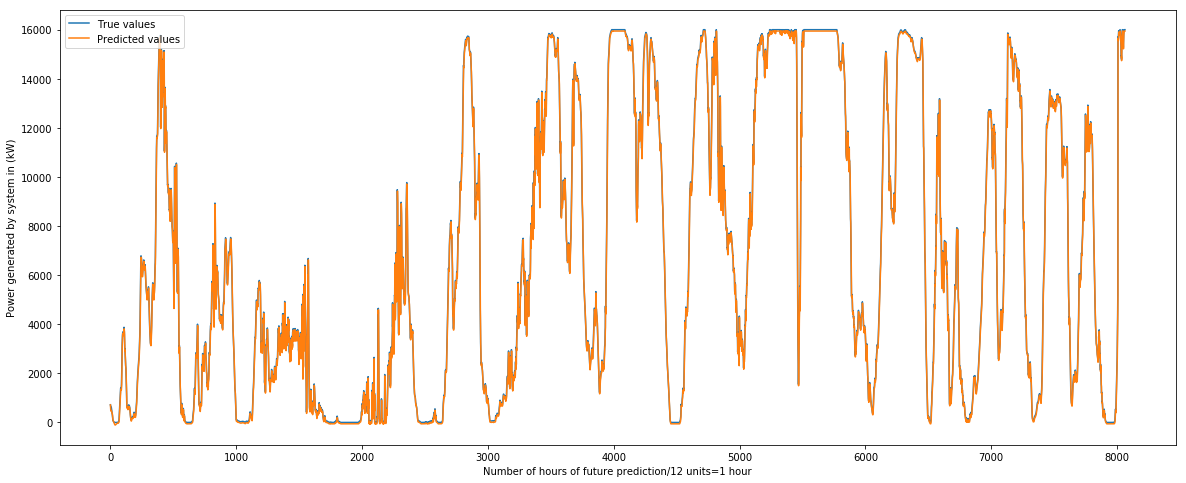

In [19]:
# Plot between the predicted power by the system and the number of hours
from matplotlib import pyplot
pyplot.figure(figsize=(20,8))
pyplot.plot(Expectation_plot, label="True values")
pyplot.plot(Pred_plot, label="Predicted values")
pyplot.xlabel("Number of hours of future prediction/12 units=1 hour")
pyplot.ylabel("Power generated by system in (kW)")
pyplot.legend()
pyplot.show()

In [18]:
# Calculating Mean Absolute Percent Error - Performance Evaluation
from sklearn.metrics import mean_squared_error
mape = (np.mean(np.abs((Expectation - Prediction) / Expectation))*100)
print("Calculation of the Mean Absolute Percent Error: ", mape )

Calculation of the Mean Absolute Percent Error:  28.76607242011218
